In [1]:
#%%
#importing the relevant libraries which will be used for this simulation 

import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from numpy import genfromtxt
import seaborn as sns
import random 
sns.set_theme()
from tqdm import tqdm
from numba import jit
import scipy.stats as st
import seaborn as sn

In [2]:

#%%
"""going to firstly begin by investigating the various maps assocatied with the data, 
looking into the 51 cities nodes and thereafter the 280, then proceed to the 442
"""
#%%
# Get the right df shape to visualize the route configuration
def arrange_df_for_plotting(df):
    df.columns = ['x', 'y']
    df = df.assign(city=np.arange(1,df.shape[0] +1))
    return df

# Plot the route configuration
def graph_plotter_normal(df, name):
    fig, ax = plt.subplots(figsize=(12,12))
    p1 = sns.scatterplot(x="x", y="y", hue = "city", s = 150, data=df)

    if name == "51 cities":
        for line in range(1,df.shape[0] +1):
            p1.text(df.x[line]+1, df.y[line], 
            df.city[line], horizontalalignment='left', 
            size='large', color='black')

    elif name == "280 cities":
        for line in range(1,df.shape[0] +1):
            p1.text(df.x[line]+1, df.y[line], 
            df.city[line], horizontalalignment='left', 
            size='large', color='black') 

    elif name == "442 cities":
        for line in range(1,df.shape[0] +1):
            p1.text(df.x[line]+1, df.y[line], 
            df.city[line], horizontalalignment='left', 
            size='medium', color='black')

    ax.set_xlabel('x-coordinate', fontsize =15)
    ax.set_ylabel('y-coordinate', fontsize = 15)
    ax.set_title('{} visualization'.format(name), fontsize = 16)
    plt.setp(p1.get_legend().get_texts(), fontsize='13') 
 
    # for legend title
    plt.setp(p1.get_legend().get_title(), fontsize='13')   

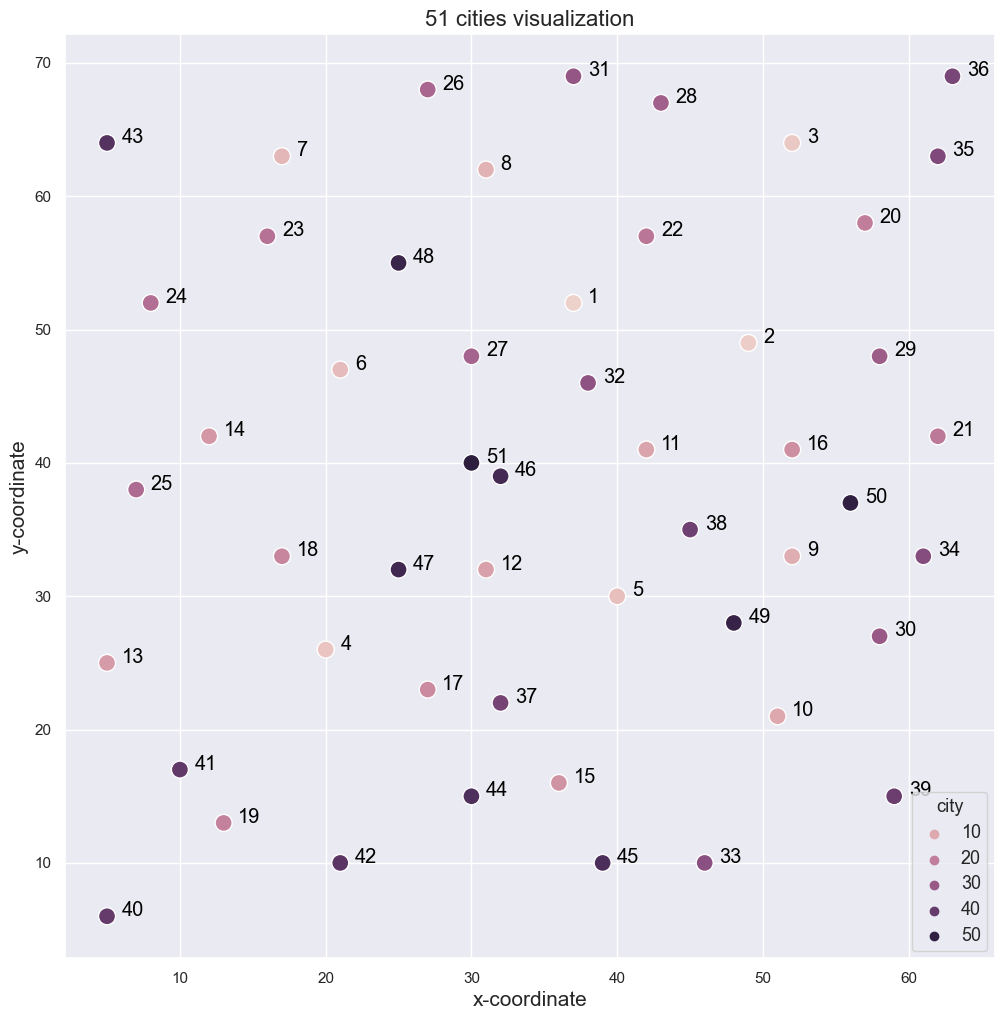

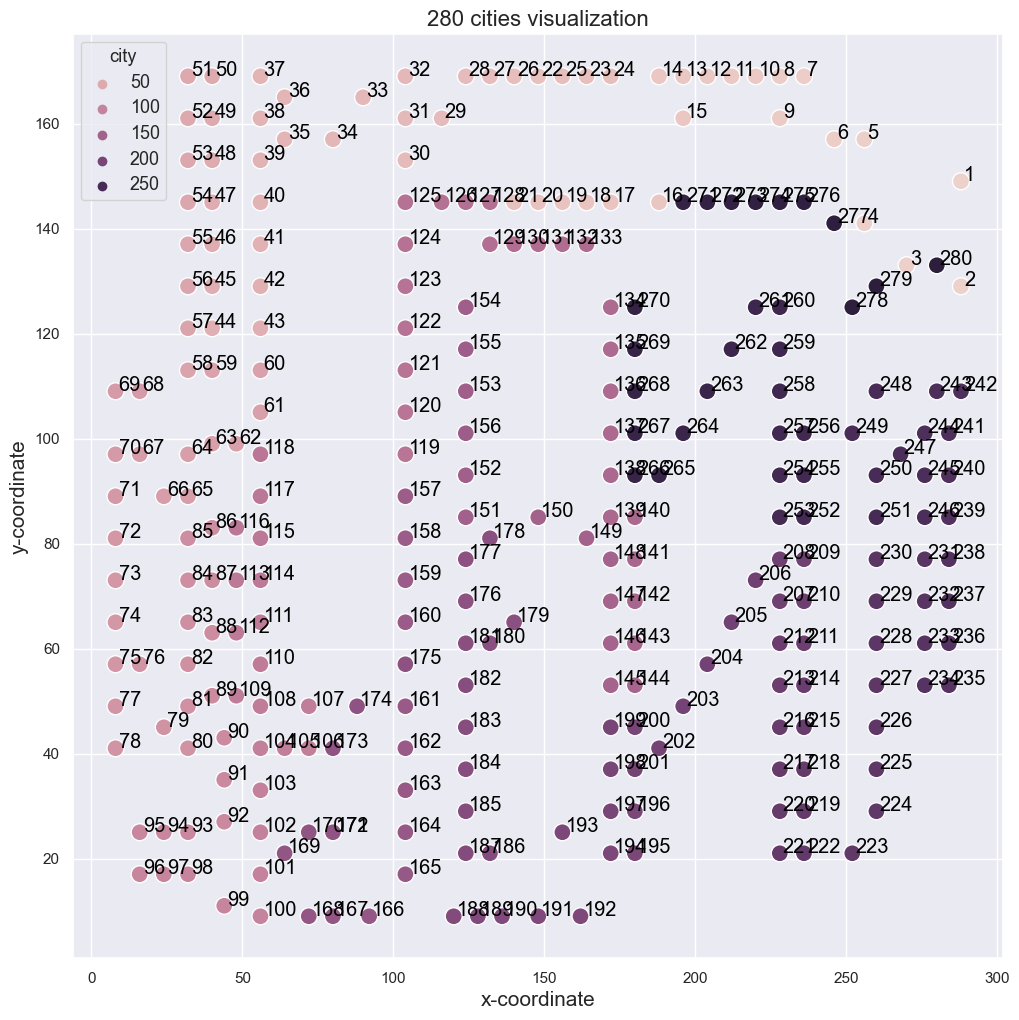

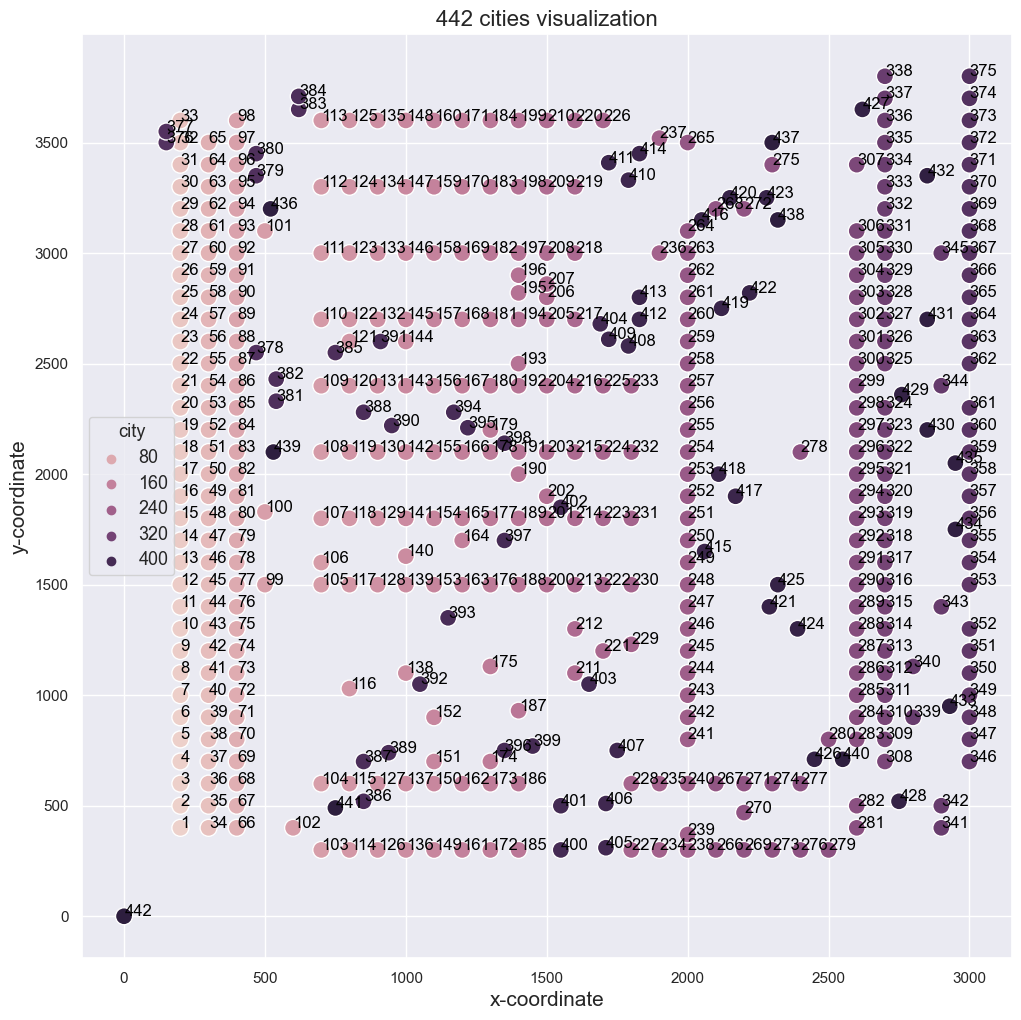

In [3]:
#%%
##%#%#%#%#%#%#%#%#%#%#%##%#% loading the data and preparing it for plotting #%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%
#%#%#%#%#%#%#%#%#%#%#%#%#%#%
route_51 = pd.read_csv('TSP-Configurations/eil51.tsp.txt', delimiter=' ', index_col= 0, header = None)
route_51 = arrange_df_for_plotting(route_51)


route_280 = pd.read_csv('TSP-Configurations/a280.tsp.txt', delimiter=' ', index_col= 0, header = None)
route_280 = arrange_df_for_plotting(route_280)

route_442 = pd.read_csv('TSP-Configurations/pcb442.tsp.txt', delimiter=' ', index_col= 0, header = None)
route_442 = arrange_df_for_plotting(route_442)
#%%
#%#%#%#%#%#%#%#%#%#%#%#%#%#% plotting the data #%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%

graph_plotter_normal(route_51, "51 cities")
graph_plotter_normal(route_280, "280 cities")
graph_plotter_normal(route_442, "442 cities")

In [4]:
#%%
#%#%#%#%#%#%#%#%#%#%#%#%#%#% FUNCTIONS #%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%
def generate_distance_matrix(df):
    matrix = pd.DataFrame(data = np.zeros((len(df), len(df))), index = np.arange(1,len(df)+1),columns = np.arange(1,len(df)+1))
    for index, row_fixed in df.iterrows():
        for index2, row_iteration in df.iterrows():
            x_change = row_fixed["x"] - row_iteration["x"]
            y_change = row_fixed["y"] - row_iteration["y"]
            euclidean_distance = (x_change**2 + y_change**2)**0.5
            # print("the distance for this combination is: {}".format(euclidean_distance))
            matrix.loc[index, index2] = euclidean_distance
    return matrix

#Calculates eucledian distance
def distance(d_df, route):
    distance = 0
    for i in range(len(route)-1):
        distance += d_df.loc[route[i], route[i+1]]
    return distance

#Generate the first path randomly
def generate_initial_path(df, if_replicable):

    if if_replicable == True:
        random.seed(10)
        random_route = [1] + [int(x) for x in random.sample(list(np.arange(2,(len(df.index)+1))), len(df.index)-1)] + [1]
    else: 
        random_route = [1] + [int(x) for x in random.sample(list(np.arange(2,(len(df.index)+1))), len(df.index)-1)] + [1]    
        
    return random_route

def swap(path, swap_first, swap_last):
    path_updated = np.concatenate((path[0:swap_first],
                                    path[swap_last:-len(path) + swap_first - 1:-1],
                                    path[swap_last + 1:len(path)]))

    return path_updated.tolist()

def swap_1(route):
    new_route = route[1:-1]
    pos_1, pos_2 = random.sample(range(0, len(new_route)), 2)
    new_route[pos_1], new_route[pos_2] = new_route[pos_2], new_route[pos_1]
    return [1] + new_route + [1]

def Temperature(n, a, b):
    T = a / np.log(n + b)
    return T

def fast_Temp(t, n):
    T = t / float(n + 1)
    return T

#%%
#This is the computational intense algorithm that has not been analysed
def two_opt_2(Markov_chain_length, inital_route, distance_matrix,t0, stop):

    dist = distance(distance_matrix , inital_route)
    T = t0
    cost_record = [dist]
    routes = []

    best_route_cost = dist
    best_route = inital_route
    c = 0
    for k in tqdm(range(stop)):
        for i in range(Markov_chain_length):
            for swap_first in range(1, len(inital_route) - 2):
                for swap_last in range(swap_first + 1, len(inital_route) - 1):

                    before_start = best_route[swap_first - 1]
                    start = best_route[swap_first]
                    end = best_route[swap_last]
                    after_end = best_route[swap_last+1]
                    before = distance_matrix[before_start][start] + distance_matrix[end][after_end]
                    after = distance_matrix[before_start][end] + distance_matrix[start][after_end]

                    new_route_temp = swap(best_route, swap_first, swap_last)
                    new_distance_temp = distance(distance_matrix, new_route_temp)
                    difference_in_cost = best_route_cost - new_distance_temp

                    if after < before:
                        best_route = new_route_temp
                        best_route_cost = new_distance_temp

                    else:
                        # Acceptance probability
                        P = min(np.exp(difference_in_cost/T), 1)
                        # Accept or not?
                        if random.uniform(0,1) < P:
                            best_route = new_route_temp
                            best_route_cost = new_distance_temp
                            
        T = T - t0/stop
        c += 1
        cost_record.append(distance(distance_matrix, best_route))
        routes.append(best_route)

    return routes, best_route, cost_record
    
#%%
# This is the Simulated Annealing algorithm that has been heavily analysed.
def two_opt(Markov_chain_length, inital_route, distance_matrix, t0, stop, cooling, alpha):

    dist = distance(distance_matrix , inital_route)
    T = t0
    cost_record = [dist]
    routes = []
    state = []
    best_route_cost = dist
    best_route = inital_route
    k = 0
    accept_bad_list = [] #bad configuration is accepted
    decline_bad_list = [] #bad configuration is not accepted
    accept_bad = 0
    decline_bad = 0
    
    for k in tqdm(range(stop)):
        k+=1
        for i in range(Markov_chain_length):
            # for swap_first in range(1, len(inital_route) - 2):
            #     for swap_last in range(swap_first + 1, len(inital_route) - 1):
            new_route = swap_1(best_route)
            new_distance = distance(distance_matrix, new_route)
            
            difference_in_cost = best_route_cost - new_distance
            if difference_in_cost > 0: 
                best_route = new_route
                best_route_cost = new_distance
            else:
                # Acceptance probability
                #Energy = np.exp(difference_in_cost/T)
                
                P = min(np.exp(difference_in_cost/T), 1)
                # Accept or not?
                state.append(P)
                if random.uniform(0,1) < P:
                    best_route = new_route
                    best_route_cost = new_distance
                    accept_bad += 1
                    accept_bad_list.append(accept_bad)
                    decline_bad_list.append(0)
                else:
                    decline_bad += 1
                    decline_bad_list.append(decline_bad)
                    accept_bad_list.append(0)
                    
           
        cost_record.append(distance(distance_matrix, best_route))
        routes.append(best_route)
        if cooling == None:
            T = T 
        elif cooling == "normal":
            T = T - t0/stop
        elif cooling == "10%":
            T = T - (T * 0.1)
            
        else:
            T = cooling_schedule(k, cooling, T, alpha)
    return routes, best_route, cost_record, state, #accept_bad_list, #decline_bad_list

def cooling_schedule(k, cooling, T, alpha):
    if cooling == "exponential":
        T = T * alpha**k     #0.8 < alpha < 0.9
    
    elif cooling == "linear":
        T = T / (1+alpha*k)  #alpha > 0
    
    elif cooling == "logarithmic":
        T = T / (1 + alpha * np.log(1+k)) #alpha > 1
        
    elif cooling == "quadratic":
        T = T / (1 + alpha * k**2)  #alpha > 0
        
    else:
        return ("Please give a valid cooling schedule: exponential, linear, logarithmic, quadratic")
        
    return T

def calculate_confidence_interval(matrix):
    """This function generates a 95% confidence interval for a matrix of areas calculated using MC simulations
    Args:
        matrix (numpy array 2D): matrix containing all area computations
    Returns:
        numpy array: array of confidence intervals for the average of each simulation
    """

    cis = np.ones(shape = (1,2))

    for i in matrix:
        data = i 
        interval = np.array(st.t.interval(alpha=0.95, df=(matrix.shape[1])-1, loc=np.mean(data), scale=st.sem(data)))
        interval = interval.reshape(1,2)
        cis = np.vstack((cis, interval))

    return cis

In [5]:
# %%
path = generate_initial_path(route_280, False)
dx = generate_distance_matrix(route_280)
#%%
# a,b,c = two_opt_2(20, path, dx, 50, 80)

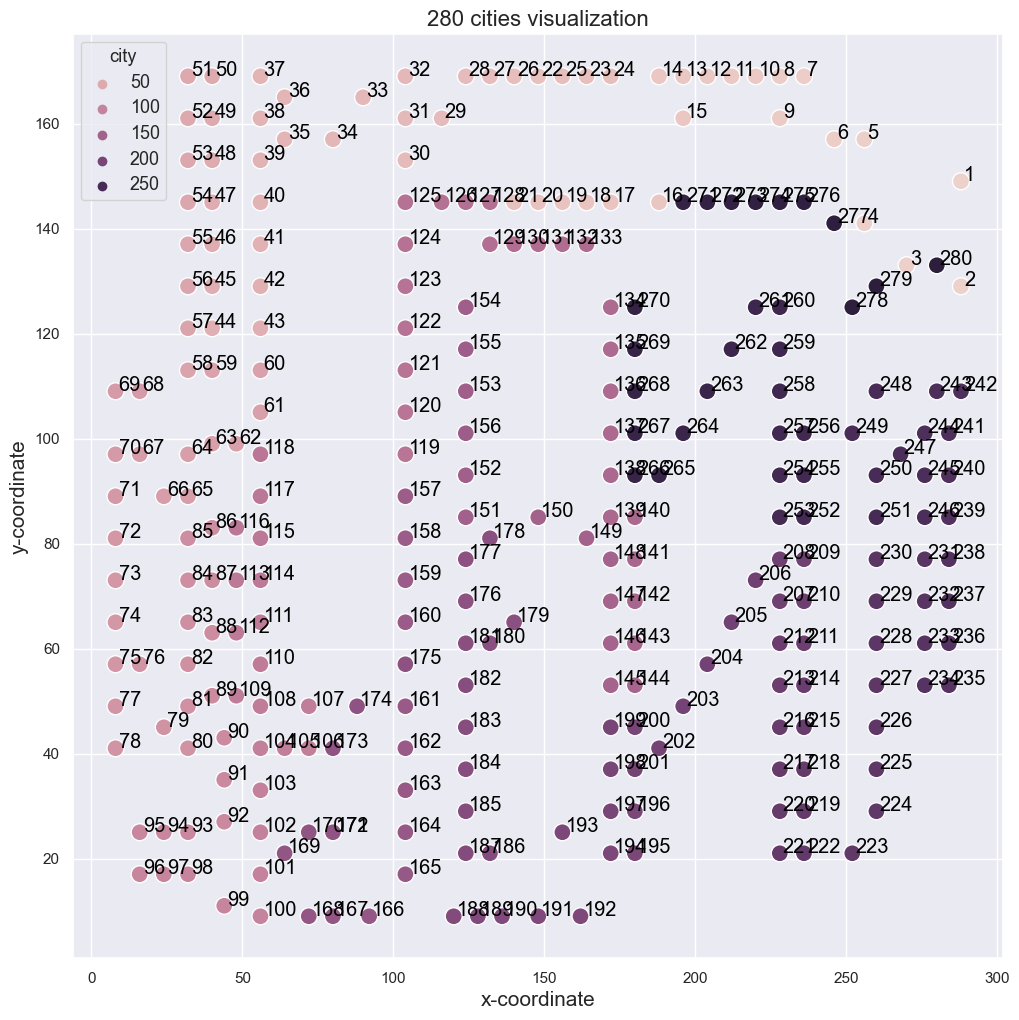

In [13]:
graph_plotter_normal(route_280, "280 cities")

# Initial temperature check t = 0  ->   100

In [72]:
temp_result = genfromtxt('TSP_data/T5-100_result.csv')

In [73]:
"""
markov_chain_length = 750
num_iterations = 750
T0 = [5, 10, 20, 50, 100]
cooling = "normal"
temp_result = []
temp_energy = []
accepted = []
declined = []
for i in range(len(T0)):
    a,b,c, energy, acc, dec = two_opt(markov_chain_length, path, dx, T0[i], num_iterations, cooling, alpha = None)
    temp_result.append(c)
    temp_energy.append(energy)
    accepted.append(acc)
    declined.append(dec)
"""

'\nmarkov_chain_length = 750\nnum_iterations = 750\nT0 = [5, 10, 20, 50, 100]\ncooling = "normal"\ntemp_result = []\ntemp_energy = []\naccepted = []\ndeclined = []\nfor i in range(len(T0)):\n    a,b,c, energy, acc, dec = two_opt(markov_chain_length, path, dx, T0[i], num_iterations, cooling, alpha = None)\n    temp_result.append(c)\n    temp_energy.append(energy)\n    accepted.append(acc)\n    declined.append(dec)\n'

In [257]:
#np.savetxt("TSP_data/T5-100_result.csv", temp_result)

In [74]:
T0 = [5, 10, 20, 50, 100]

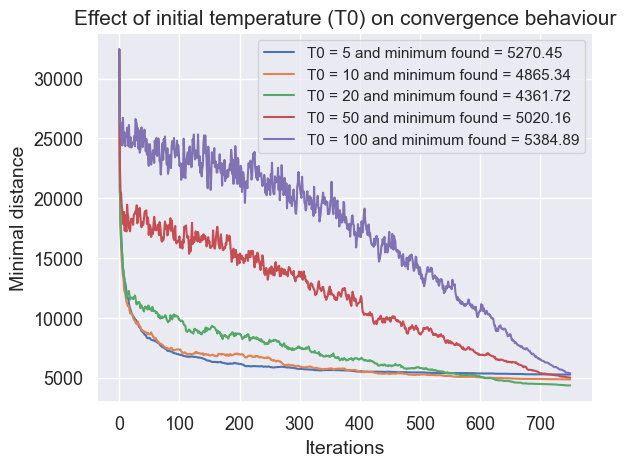

In [76]:
for i in range(len(T0)):
    plt.plot(temp_result[i], label = "T0 = %d and minimum found = %.2f" % (T0[i], temp_result[i][-1]) )
    plt.legend()
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Iterations", fontsize = 14)
plt.ylabel("Minimal distance", fontsize = 14)
plt.title("Effect of initial temperature (T0) on convergence behaviour", fontsize = 15)
plt.savefig("Figures/T0_check5-100.png", bbox_inches = 'tight')

# Initial temperature check t = 200, 500, 1000, 2000, 5000, 10000

In [79]:
T0 = [200, 500, 1000, 2000, 5000]

In [83]:
T0_check2 = genfromtxt("TSP_data/check_t0_200to5000")

In [81]:
"""
markov_chain_length = 1000
num_iterations = 5000
cooling = "normal"
temp_result = []
temp_energy = []
accepted = []
declined = []
for i in range(len(T0)):
    a,b,c, energy = two_opt(markov_chain_length, path, dx, T0[i], num_iterations, cooling, alpha = None)
    temp_result.append(c)
    temp_energy.append(energy)
"""

'\nmarkov_chain_length = 1000\nnum_iterations = 5000\ncooling = "normal"\ntemp_result = []\ntemp_energy = []\naccepted = []\ndeclined = []\nfor i in range(len(T0)):\n    a,b,c, energy = two_opt(markov_chain_length, path, dx, T0[i], num_iterations, cooling, alpha = None)\n    temp_result.append(c)\n    temp_energy.append(energy)\n'

In [82]:
#np.savetxt("TSP_data/check_t0_200to5000", temp_result)

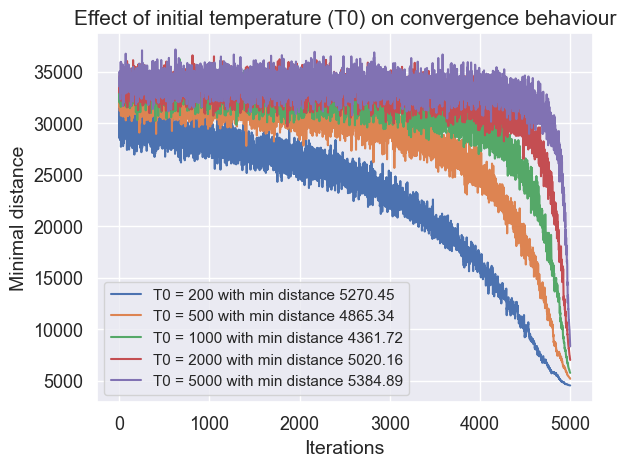

In [84]:
for i in range(len(T0)):
    plt.plot(T0_check2[i], label = "T0 = %d with min distance %.2f" % (T0[i], temp_result[i][-1]))
    
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Iterations", fontsize = 14)
plt.ylabel("Minimal distance", fontsize = 14)
plt.title("Effect of initial temperature (T0) on convergence behaviour", fontsize = 15)
plt.legend()
plt.savefig("Figures/T0_check200-5000.png", bbox_inches = 'tight')

# Acceptance ratio of bad route

In [50]:

T0 = list(np.arange(1, 11, 1)) + list(np.arange(20, 110, 10)) + list(np.arange(100, 1100, 100))
markov_chain_length = 100
num_iterations = 100
num_simulations = 10
cooling = None


T0_stack_list_result = []
T0_stack_list_energy = []

for i in range(len(T0)):
    temp_result = []
    temp_energy = []
    for j in range(num_simulations):
        a,b,c, energy = two_opt(markov_chain_length, path, dx, T0[i], num_iterations, cooling, alpha = None)
        temp_result.append(c)
        temp_energy.append(energy)
    T0_stack_list_result.append(temp_result)   
    T0_stack_list_energy.append(temp_energy)
    

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.88it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.97it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.80it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.81it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.80it/s]


In [55]:
mean_energy_acc = []
mean_energy_cis = []
mean_energy_std = []
for i in range(len(T0)):
    mean_energy = []
    for n in range(num_simulations):
        mean_energy.append(np.mean(T0_stack_list_energy[i][n]))
    mean_energy_acc.append(np.mean(mean_energy))
    mean_energy_cis.append(mean_energy)
    mean_energy_std.append(np.std(mean_energy))

In [56]:
cis_acc = calculate_confidence_interval(np.array(mean_energy_cis))
cis_acc = cis_acc[1:]

C:\Users\ysijp\AppData\Local\Temp\ipykernel_11688\1375187952.py:190: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  interval = np.array(st.t.interval(alpha=0.95, df=(matrix.shape[1])-1, loc=np.mean(data), scale=st.sem(data)))


In [58]:
np.savetxt("TSP_data/acceptance_probability_avg_T01-1000.csv", mean_energy_acc)
np.savetxt("TSP_data/acceptance_probability_cis_T01-1000.csv", cis_acc)
np.savetxt("TSP_data/acceptance_probability_std_T01-1000.csv", mean_energy_std)

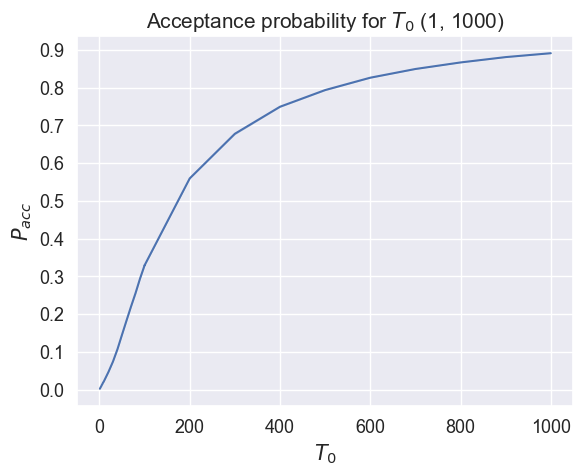

In [67]:
yticks = np.linspace(0, 0.9, 10)
plt.plot(T0, mean_energy_acc)
plt.fill_between(T0, cis_acc.T[0], cis_acc.T[1], alpha = 0.3, label = "95% confidence interval")
plt.xlabel("$T_{0}$", fontsize = 15)
plt.xticks(fontsize = 13)
plt.yticks(yticks, fontsize = 13)
plt.ylabel("$P_{acc}$", fontsize = 15)
plt.title("Acceptance probability for $T_{0}$ (1, 1000)", fontsize = 15)
plt.savefig("Figures/acceptance_probability_T01-1000.png", bbox_inches='tight')
plt.show()

# Acceptance probability of 0.5 lies between T0160 and T0180

In [ ]:
#Changed markov_chain_length to 100 from 250, because obtained the same result

In [68]:
mean_energy_acc = genfromtxt("TSP_data/acceptance_probability_avg_T0160-180.csv")
cis_acc = genfromtxt("TSP_data/acceptance_probability_cis_T0160-180.csv")
std_acc = genfromtxt("TSP_data/acceptance_probability_std_T0160-180.csv")

In [15]:
"""
markov_chain_length = 100
num_iterations = 100
num_simulations = 30
cooling = None
T0 = np.arange(160, 181, 1)

T0_stack_list_result = []
T0_stack_list_energy = []

for i in range(len(T0)):
    temp_result = []
    temp_energy = []
    for j in range(num_simulations):
        a,b,c, energy, acc, dec = two_opt(markov_chain_length, path, dx, T0[i], num_iterations, cooling, alpha = None)
        temp_result.append(c)
        temp_energy.append(energy)
    T0_stack_list_result.append(temp_result)   
    T0_stack_list_energy.append(temp_energy)
"""

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.17it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.11it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.07it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.16it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.15it/s]


In [111]:
"""
mean_energy_acc = []
mean_energy_cis = []
mean_energy_std = []
for i in range(len(T0)):
    mean_energy = []
    for n in range(num_simulations):
        mean_energy.append(np.mean(T0_stack_list_energy[i][n]))
    mean_energy_acc.append(np.mean(mean_energy))
    mean_energy_cis.append(mean_energy)
    mean_energy_std.append(np.std(mean_energy))
"""

In [112]:
"""
cis_acc = calculate_confidence_interval(np.array(mean_energy_cis))
cis_acc = cis_acc[1:]
"""

C:\Users\ysijp\AppData\Local\Temp\ipykernel_20456\418506276.py:190: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  interval = np.array(st.t.interval(alpha=0.95, df=(matrix.shape[1])-1, loc=np.mean(data), scale=st.sem(data)))


In [116]:
"""
np.savetxt("TSP_data/acceptance_probability_avg_T0160-180.csv", mean_energy_acc)
np.savetxt("TSP_data/acceptance_probability_cis_T0160-180.csv", cis_acc)
np.savetxt("TSP_data/acceptance_probability_std_T0160-180.csv", mean_energy_std)
"""

In [69]:
T0 = np.arange(160, 181, 1)

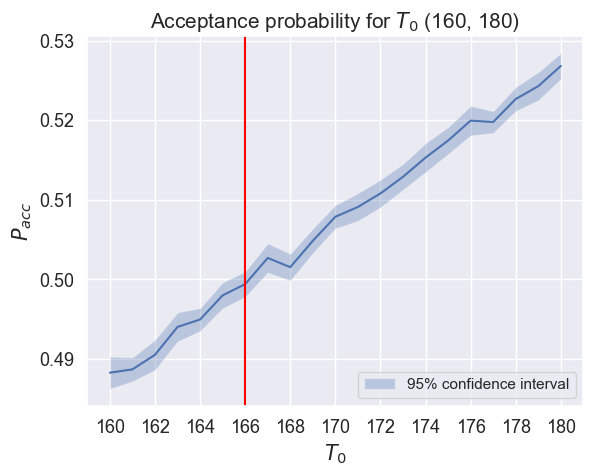

In [70]:
xticks = np.arange(160, 182, 2)
plt.plot(T0, mean_energy_acc)
plt.fill_between(T0, cis_acc.T[0], cis_acc.T[1], alpha = 0.3, label = "95% confidence interval")
plt.xlabel("$T_{0}$", fontsize = 15)
plt.xticks(xticks, fontsize = 13)
plt.yticks(fontsize = 13)
plt.ylabel("$P_{acc}$", fontsize = 15)
plt.axvline(166, color = 'red')
plt.title("Acceptance probability for $T_{0}$ (160, 180)", fontsize = 15)
plt.legend()
plt.savefig("Figures/acceptance_probability_T0160-180.png", bbox_inches='tight')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


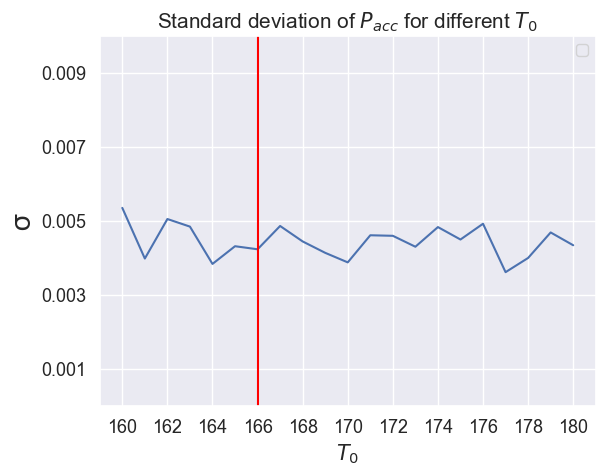

In [34]:
yticks = [0.001, 0.003, 0.005, 0.007, 0.009]
plt.plot(T0, std_acc)
plt.ylim([0, 0.01])
plt.xlabel("$T_{0}$", fontsize = 15)
plt.ylabel('\u03C3', fontsize = 20)
plt.xticks(xticks, fontsize = 13)
plt.yticks(yticks, fontsize = 13)
plt.axvline(166, color = 'red')
plt.title("Standard deviation of $P_{acc}$ for different $T_{0}$", fontsize = 15)
plt.legend()
plt.savefig("Figures/acceptance_probability_STD_T0160-180.png", bbox_inches='tight')
plt.show()

# T0 = 166 it is! Now let's see the convergence

In [176]:
cooling = "normal"
alpha = None
markov_chain_length = 1000
num_iterations = 1000
T0 = 166
cost_record_list = []

a, b, c, energy = two_opt(markov_chain_length, path, dx, T0, num_iterations, cooling, alpha)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [27:41<00:00,  1.66s/it]


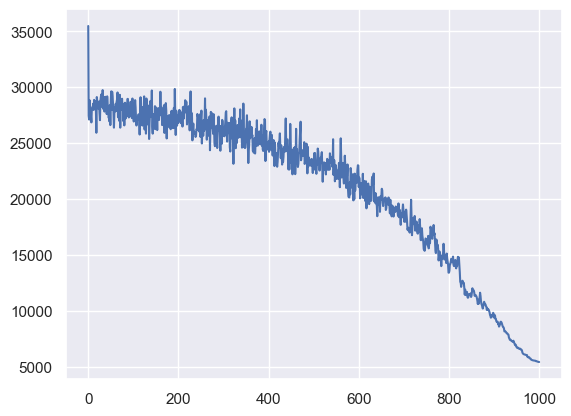

In [177]:
plt.plot(c)

In [203]:
cooling = "10%"
alpha = None
markov_chain_length = 1000
num_iterations = 1000
T0 = 166
cost_record_list = []

a, b, c, energy = two_opt(markov_chain_length, path, dx, T0, num_iterations, cooling, alpha)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [27:18<00:00,  1.64s/it]


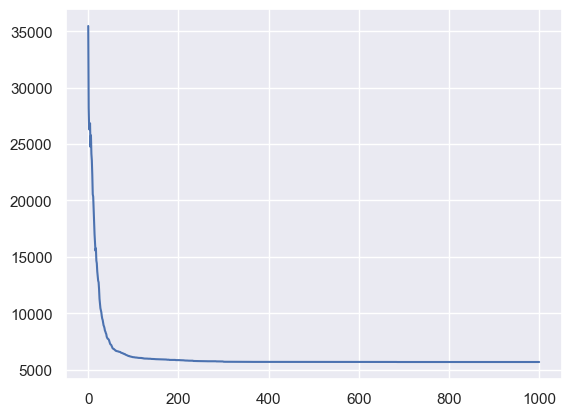

In [205]:
plt.plot(c)

# Cooling schedules

# Let's check the effect of the markov chain

### $T_{0}$ = 166

In [90]:
chain_heatmap_166 = genfromtxt("TSP_data/markovchain_vs_its_heatmap_T0=166_normal_cooling")

In [190]:
"""
markov_chain_length = [10, 50, 100, 250, 500, 750, 1000]
num_iterations = [10, 50, 100, 250, 500, 750, 1000]
T0 = 166

chain_heatmap = np.zeros((len(markov_chain_length), len(num_iterations)))
all_results_heatmap = []
for i in range(len(markov_chain_length)):
    for j in range(len(num_iterations)):
        a,b,c, energy = two_opt(markov_chain_length[i], path, dx, T0, num_iterations[j], "normal", None)
        chain_heatmap_166[i,j] = c[-1]
"""

 15%|███████████▊                                                                     | 73/500 [00:01<00:07, 54.17it/s]


KeyboardInterrupt: 

In [198]:
#np.savetxt("TSP_data/markovchain_vs_its_heatmap_T0=166_normal_cooling", chain_heatmap_166)

In [93]:
markov_chain_length = [10, 50, 100, 250, 500, 750, 1000]
num_iterations = [10, 50, 100, 250, 500, 750, 1000]

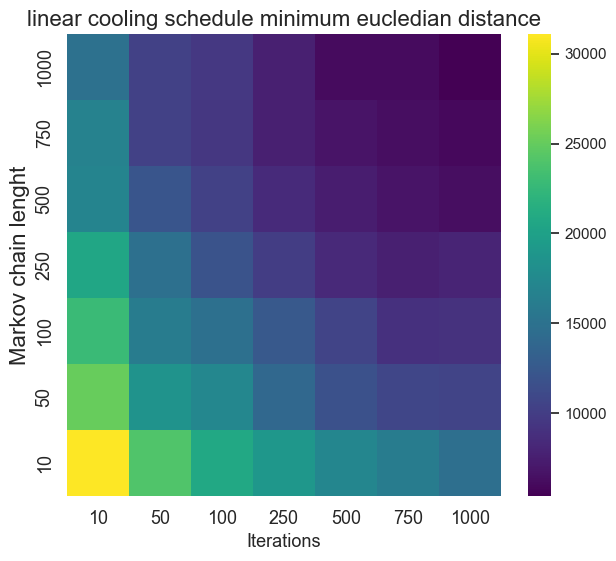

In [99]:
fig, ax = plt.subplots(figsize = (7,6))
ax = sns.heatmap(chain_heatmap_166, cmap = 'viridis')
ax.invert_yaxis()
ax.set_xlabel("Iterations", fontsize = 13)
ax.set_ylabel("Markov chain lenght", fontsize = 16)
ax.set_xticklabels(num_iterations, fontsize = 13)
ax.set_yticklabels(num_iterations, fontsize = 13)
ax.set_title("linear cooling schedule minimum eucledian distance", fontsize = 16)
plt.savefig("Figures/Heatmap_route_280_T0=166_normal_cooling.png", bbox_inches='tight', dpi = 350)
plt.show()

### $T_{0}$ = 70

In [219]:
chain_heatmap_70 = genfromtxt("TSP_data/markovchain_vs_its_heatmap_T0=70")

In [7]:
#T0 is a educated guess for a good starting temperature based on the previous experiments.
#T0 = 70 is good because when you have T0 as 10, the result will converge after 400/500 its
#Since we want check chain_length 1000 in this heatmap we need to have its at 1000 aswell


"""
markov_chain_length = [10, 50, 100, 250, 500, 750, 1000]
num_iterations = [10, 50, 100, 250, 500, 750, 1000]
T0 = 70

chain_heatmap = np.zeros((len(markov_chain_length), len(num_iterations)))
all_results_heatmap = []
for i in range(len(markov_chain_length)):
    for j in range(len(num_iterations)):
        a,b,c, energy = two_opt(markov_chain_length[i], path, dx, T0, num_iterations[j], "normal", None)
        chain_heatmap[i,j] = c[-1]
        all_results_heatmap.append(c)

np.savetxt("TSP_data/markovchain_vs_its_heatmap_T0=70", chain_heatmap)
"""

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [32:34<00:00,  1.95s/it]


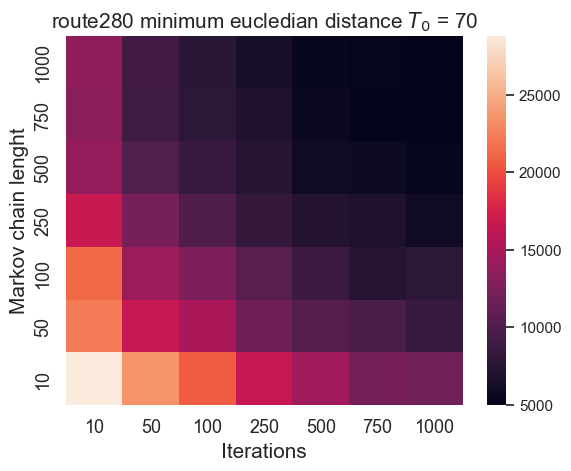

In [222]:
markov_chain_length = [10, 50, 100, 250, 500, 750, 1000]
num_iterations = [10, 50, 100, 250, 500, 750, 1000]

ax = sns.heatmap(chain_heatmap_70)
ax.invert_yaxis()
ax.set_xlabel("Iterations", fontsize = 15)
ax.set_ylabel("Markov chain lenght", fontsize = 15)
ax.set_xticklabels(num_iterations, fontsize = 13)
ax.set_yticklabels(num_iterations, fontsize = 13)
ax.set_title("route280 minimum eucledian distance $T_{0}$ = 70", fontsize = 15)
#plt.savefig("Figures/Heatmap_route_280_T0=70.png")
plt.show()

# Influence markov chain length on convergence with constant number of iterations (=1000)

In [ ]:
min_distance1 = genfromtxt("TSP_data/chainplot_T0166_1iteration")

In [13]:
"""
markov_chain_length = list(np.arange(1, 10, 1)) + list(np.arange(10, 100, 10)) + list(np.arange(100, 1000, 100))
num_simulations = 10
num_iterations = 1000
T0 = 166
cooling = "normal"
min_distance = []
all_distance = []
for i in range(len(markov_chain_length)):
    a,b,c, energy = two_opt(markov_chain_length[i], path, dx, T0, num_iterations, cooling, None)
    min_distance.append(c[-1])
    all_distance.append(c)
"""

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [24:28<00:00,  1.47s/it]


In [35]:
#np.savetxt("TSP_data/chainplot_T0166_1iteration", min_distance)

In [31]:
markov_chain_length = list(np.arange(1, 10, 1)) + list(np.arange(10, 100, 10)) + list(np.arange(100, 1000, 100))

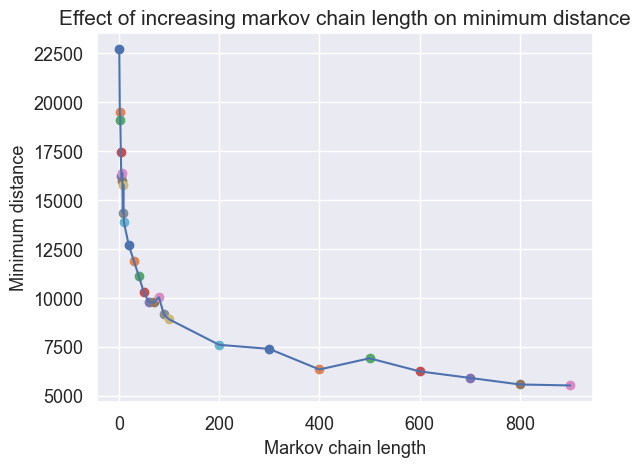

In [34]:
plt.plot(markov_chain_length, min_distance1)
for i in range(len(markov_chain_length)):
    plt.scatter(markov_chain_length[i], min_distance1[i])
plt.title("Effect of increasing markov chain length on minimum distance", fontsize = 15)
plt.xlabel("Markov chain length", fontsize = 13)
plt.ylabel("Minimum distance", fontsize = 13)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
#plt.savefig("Figures/chainplot_1iteration")
plt.show()

In [ ]:
#Multiple simulations

In [42]:
min_distance2 = genfromtxt("TSP_data/chainplot_T0166_10_iterations.csv")

In [36]:
"""
markov_chain_length = [1, 10, 20, 50, 100, 200, 300, 400, 500, 700, 1000]
num_simulations = 10
num_iterations = 1000
T0 = 166
cooling = "normal"
min_distance_stack = []
all_distance_stack = []
for k in range(num_simulations):
    min_distance = []
    all_distance = []
    for i in range(len(markov_chain_length)):
        a,b,c, energy = two_opt(markov_chain_length[i], path, dx, T0, num_iterations, cooling, None)
        min_distance.append(c[-1])
        all_distance.append(c)
        
    min_distance_stack.append(min_distance)
    all_distance_stack.append(all_distance)
"""

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [26:26<00:00,  1.59s/it]


In [ ]:
#min_distance_stack = np.array(min_distance_stack).T

In [126]:
#np.savetxt("TSP_data/chainplot_T0166_10_iterations.csv", min_distance_stack)

In [43]:
cis = calculate_confidence_interval(min_distance2)
cis = cis[1:]

C:\Users\ysijp\AppData\Local\Temp\ipykernel_11688\1375187952.py:190: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  interval = np.array(st.t.interval(alpha=0.95, df=(matrix.shape[1])-1, loc=np.mean(data), scale=st.sem(data)))


In [44]:
avg_distance_chainplot = []
for i in range(len(min_distance2)):
    avg_distance_chainplot.append(np.mean(min_distance2[i]))

In [46]:
markov_chain_length = [1, 10, 20, 50, 100, 200, 300, 400, 500, 700, 1000]

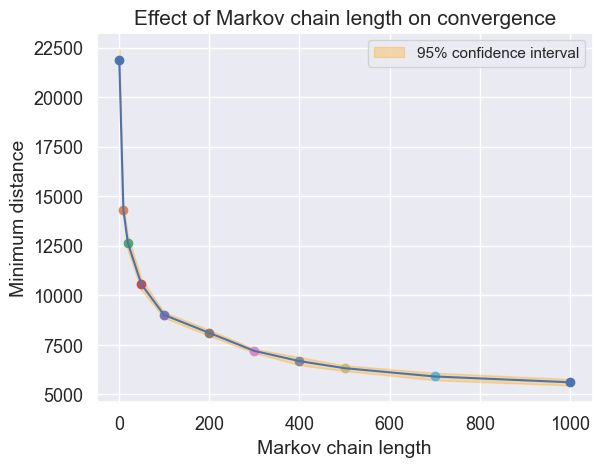

In [49]:
plt.plot(markov_chain_length, avg_distance_chainplot)   
plt.fill_between(markov_chain_length, cis.T[0], cis.T[1], alpha = 0.3, color = 'orange', label = "95% confidence interval")
for i in range(len(markov_chain_length)):
    plt.scatter(markov_chain_length[i], np.mean(min_distance2[i]))
    
    
plt.xlabel("Markov chain length", fontsize = 14)
plt.ylabel("Minimum distance", fontsize = 14)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.legend()
plt.title("Effect of Markov chain length on convergence", fontsize = 15)
plt.savefig("Figures/Chainplot_10iterations.png", bbox_inches = 'tight')
plt.show()

# Lets run it one time with very large iterations

In [87]:
c_10k = genfromtxt("TSP_data/convergence_10kiterations_normallinear.csv")
c_20k = genfromtxt("TSP_data/convergence_20kiterations_normallinear.csv")

In [137]:
"""
markov_chain_length = 500
num_iterations = 10000
T0 = 166
cooling = "normal"

a,b,c_10k, energy = two_opt(markov_chain_length, path, dx, T0, num_iterations, cooling, None)
"""

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [2:14:41<00:00,  1.24it/s]


In [140]:
#np.savetxt("TSP_data/convergence_10kiterations_normallinear.csv", c_10k)

In [141]:
"""
markov_chain_length = 500
num_iterations = 20000
T0 = 166
cooling = "normal"

a,b,c_20k, energy = two_opt(markov_chain_length, path, dx, T0, num_iterations, cooling, None)
"""

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [4:32:56<00:00,  1.22it/s]


In [ ]:
#np.savetxt("TSP_data/convergence_20kiterations_normallinear.csv", c_20k)

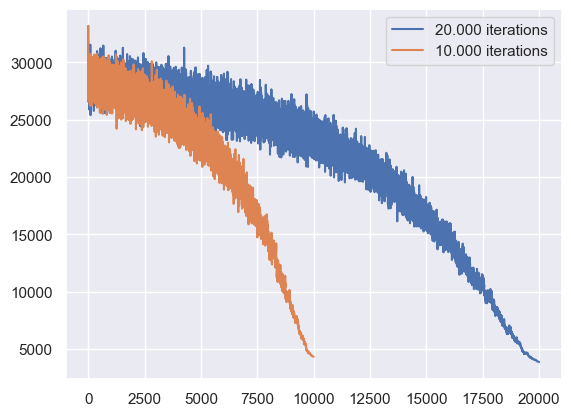

In [89]:
plt.plot(c_20k, label = "20.000 iterations")
plt.plot(c_10k, label = "10.000 iterations")
plt.legend()